In [85]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
import os.path as op
import pandas as pd
import numpy as np
import json
import os

In [2]:
import pyarrow as pa
import pyarrow.parquet as pq

In [3]:
from sklearn.cluster import AgglomerativeClustering

In [4]:
bpath = Path('../data/clustering/BNU1/similarities/')
sims = {_: pd.read_hdf(_) for _ in bpath.rglob('*similarity*h5')}
cons = {_: pd.read_hdf(_) for _ in bpath.rglob('*consistency*h5')}
dists = {tuple(_.name.split('_')[0:2]): np.loadtxt(_) for _ in bpath.rglob('*distmat*txt')}

In [5]:
def meta_stack(kvp):
    df = None
    for k, v in kvp.items():
        dset, atlas = tuple(k.name.split('_')[0:2])
        v['dataset'] = dset
        v['atlas'] = atlas
        df = pd.concat([df, v])
    return df

df_sim = meta_stack(sims)
df_con = meta_stack(cons)

In [119]:
def cluster_and_plot(df_sim, dmat, anno=False, aname=''):
    dmat = 1 - dmat
    clf = AgglomerativeClustering(n_clusters=None, affinity='precomputed',
                                  linkage='complete',
                                  distance_threshold=np.percentile(dmat, 90))
    labs = clf.fit_predict(dmat)
    unique, counts = np.unique(labs, return_counts=True)

    fig = plt.figure(figsize=(20, len(unique)*5))

    clustering = []
    for _, (l, c) in enumerate(zip(unique, counts)):
        locs = np.where(labs == l)
        tdf = df_sim.iloc[locs]
        signature = np.mean(tdf['rank_corr'])
        clustering += [{
            'label': l,
            'members': locs,
            'signature': signature
        }]
        
        plt.subplot(1, len(unique), _+1)
        if anno:
            plt.xlabel('Label: {0}  |  N: {1}'.format(l, len(locs[0])))
            plt.title(aname)
        plt.imshow(signature, cmap='cividis')
        plt.yticks([])
        plt.xticks([])

    plt.show()
    return clustering


def plot_resorted(distmat, label_list):
    csize = [len(_) for _ in label_list]
    start = [sum(csize[:_]) for _ in range(len(csize))]

    order = np.concatenate(label_list)
    resorted = distmat[:, order][order]
    
    f = plt.figure(figsize=(10, 10))
    ax = f.add_subplot(111)
    plt.imshow(resorted, cmap='inferno')

    for s, l in zip(start, csize):
        rect = patches.Rectangle((s-.5, s-0.5), l, l, linewidth=3, edgecolor='w',
                                 facecolor='none')
        ax.add_patch(rect)

    plt.yticks([])
    plt.xticks([])

    plt.show()

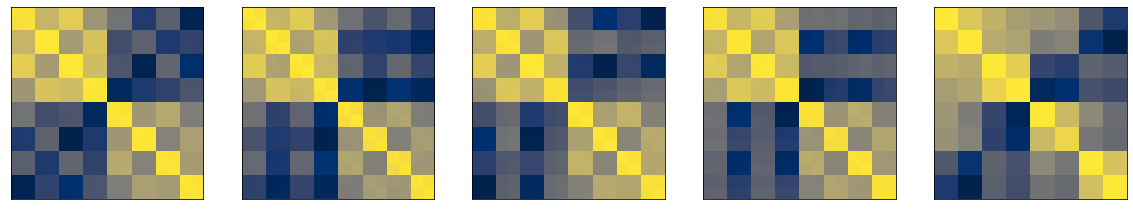

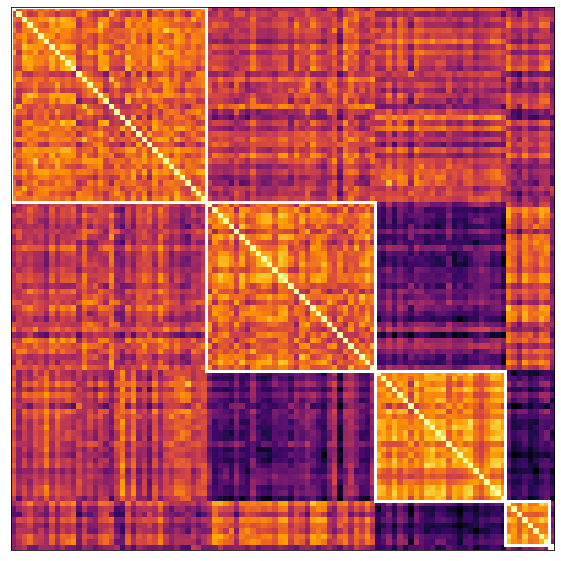

5050 100 (100, 100)


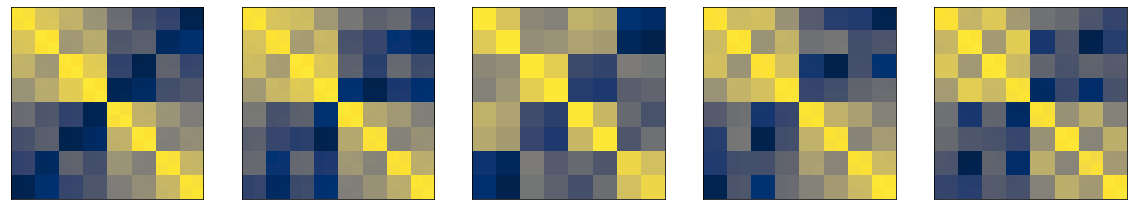

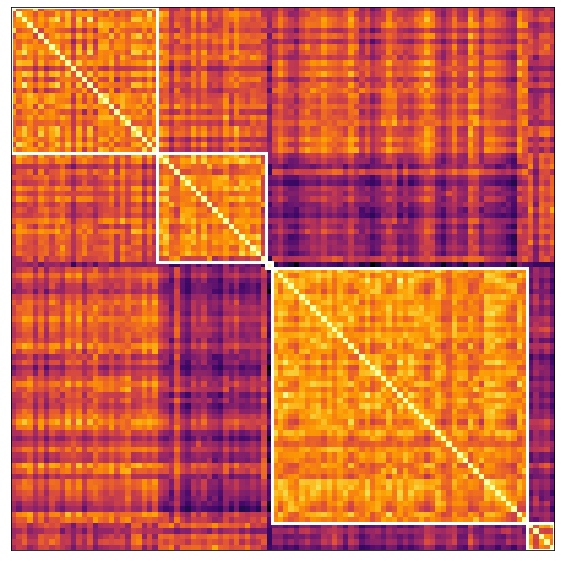

5050 100 (100, 100)


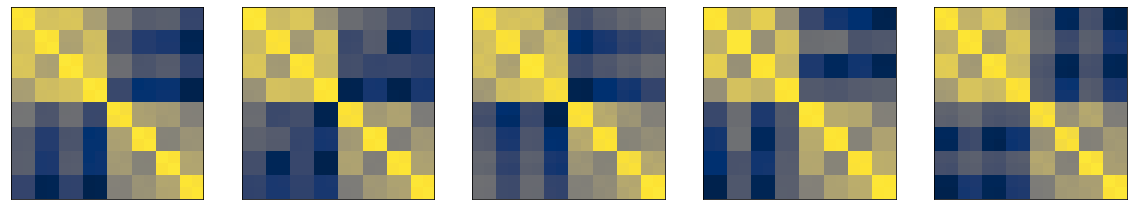

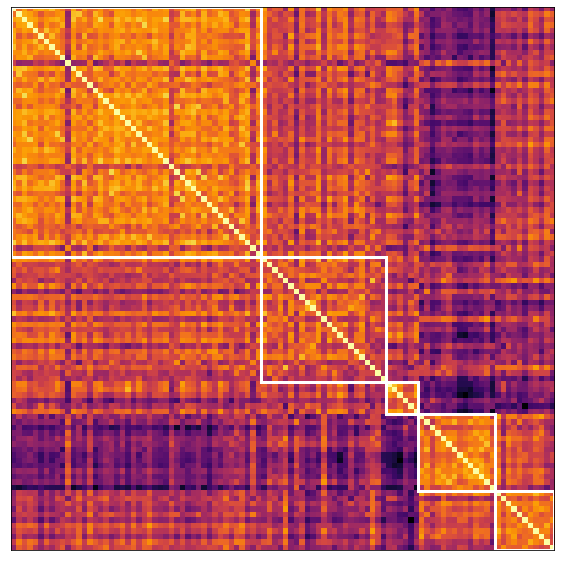

5050 100 (100, 100)


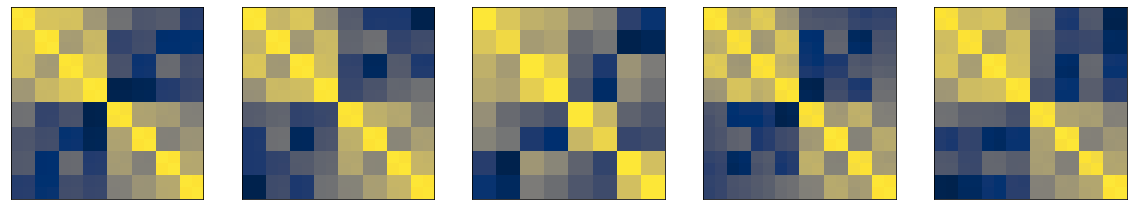

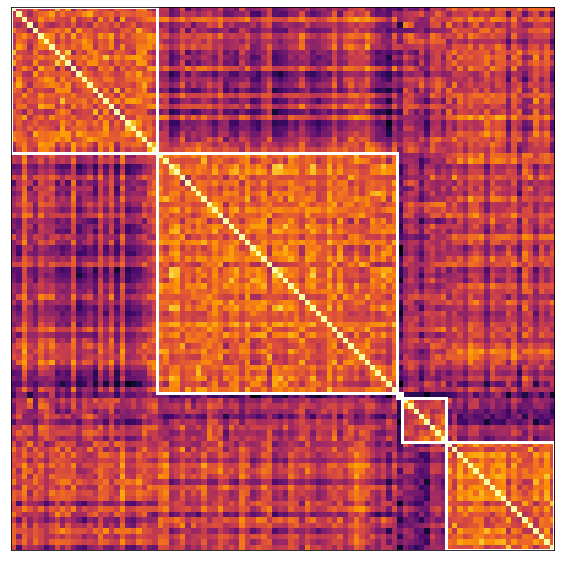

5050 100 (100, 100)


In [120]:
combos = df_sim.value_counts(['dataset', 'atlas']).index
sliced = lambda df, ds, at: df[(df['dataset'] == ds) & (df['atlas'] == at)]

clustering = {}
for ds, at in combos:
    tdf_c = sliced(df_con, ds, at)
    tdf_s = sliced(df_sim, ds, at)
    tdmat = dists[(ds, at)]
    clustering[(ds, at)] = cluster_and_plot(tdf_s, tdmat, aname=at)
    label_list = [_['members'][0] for _ in clustering[(ds, at)]]
    plot_resorted(tdmat, label_list)
    print(len(tdf_c), len(tdf_s), tdmat.shape)